# load the data

In [1]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import pandas as pd

training_data = pd.read_csv("train.csv")

price_labels = ["low", "medium", "high"]

training_data["PriceCategory"], bins = pd.qcut(
    training_data["SalePrice"],
    q=3,
    labels=price_labels,
    retbins=True,
    duplicates="drop"
)

X = training_data.drop(columns=["Id", "SalePrice", "PriceCategory"])
y = training_data["PriceCategory"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)


# preprocess the data

In [2]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# preprocess and convert to DataFrame for viewing
X_processed = preprocessor.fit_transform(X)
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)
X_processed_df = pd.DataFrame(X_processed.toarray(), columns=all_features)


# test various models and select the best

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif

# 1️⃣ Build a pipeline with a *placeholder* "selector" step
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance", VarianceThreshold(threshold=0.0)),
    ("selector", "passthrough"),
    ("classifier", LogisticRegression(solver="lbfgs", max_iter=500))
])

# 2️⃣ Tell GridSearchCV which options to try for "selector"
param_grid = {
    "selector": [
        "passthrough",
        SelectKBest(score_func=f_classif, k=50),
        SelectKBest(score_func=mutual_info_classif, k=50),
        SelectKBest(score_func=f_classif, k=100),
        SelectKBest(score_func=mutual_info_classif, k=100),
        SelectKBest(score_func=f_classif, k=150),
        SelectKBest(score_func=mutual_info_classif, k=150),
    ],
}

# 3️⃣ Wrap the pipeline in GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,             # 5-fold cross-validation
    scoring="roc_auc_ovr",
    n_jobs=-1         # use all cores (optional, speeds things up)
)

# 4️⃣ Fit the whole thing
grid.fit(X_train, y_train)

# 5️⃣ Get the best pipeline (with the best selector choice)
best_pipeline = grid.best_estimator_

print("Best ROC AUC (OvR):", grid.best_score_)
print("Best selector:", grid.best_params_["selector"])

results = pd.DataFrame(grid.cv_results_)

# Show selector, mean score, std, and rank
summary = results[[
    "rank_test_score",
    "param_selector",
    "mean_test_score",
    "std_test_score"
]]

summary = summary.sort_values("rank_test_score")


/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label,

Best ROC AUC (OvR): 0.9456790839620914
Best selector: SelectKBest(k=150)


# predict on the training test data

In [4]:
y_pred_cat = best_pipeline.predict(X_test)

# Take a look at predictions vs actual
training_results = pd.DataFrame({
    "expected": y_test.values,
    "predicted": y_pred_cat
})

training_results["correct"] = training_results["expected"] == training_results["predicted"]
training_results.to_csv("results_logistic.csv", index=False)


# evaluate the model

              precision    recall  f1-score   support

        high       0.85      0.91      0.88       139
         low       0.83      0.86      0.85       155
      medium       0.75      0.66      0.70       144

    accuracy                           0.81       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.81      0.81      0.81       438



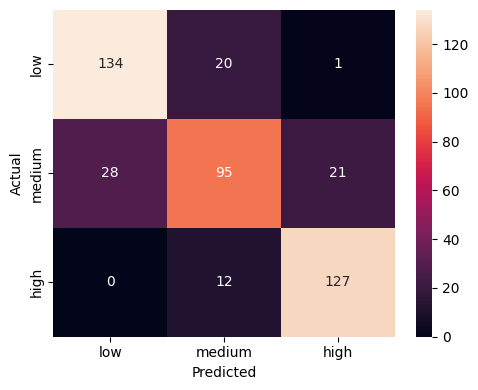

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test.values, y_pred_cat))

cm = confusion_matrix(y_test.values, y_pred_cat, labels=price_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=price_labels,
    yticklabels=price_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# run model against the test data file

In [6]:
test_data = pd.read_csv("test.csv")
predictions = best_pipeline.predict(test_data)

s = pd.Series(predictions)
counts = s.value_counts().rename("count")
percent = (counts / counts.sum() * 100).round(2).rename("percent")

summary = pd.concat([counts, percent], axis=1).reset_index()
summary = summary.rename(columns={"index": "PriceCategory"})

print(summary)


  PriceCategory  count  percent
0           low    542    37.15
1        medium    469    32.15
2          high    448    30.71
